In [3]:
!pip install tensorflow pydot

Defaulting to user installation because normal site-packages is not writeable


In [4]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, metrics
import tensorflow as tf

warnings.filterwarnings("ignore")

In [5]:
path = r"465 dataset/Axial"

data = tf.keras.utils.image_dataset_from_directory(directory = path, image_size = (128, 128), batch_size = 10000)

Found 5154 files belonging to 3 classes.


In [6]:
class_names = data.class_names
print(class_names)

['AD', 'CI', 'CN']


In [7]:
label_map = {m : n for m, n in zip(np.arange(len(class_names)), class_names)}
print(label_map)

{0: 'AD', 1: 'CI', 2: 'CN'}


In [8]:
for images, labels in data:
    X = images.numpy().astype("uint8")
    y = labels.numpy().astype("uint8")

print(X.shape, y.shape)

(5154, 128, 128, 3) (5154,)


In [9]:
X_gray = np.zeros(shape = (*X.shape[:-1], 1))

for idx, img in enumerate(X):
    X_gray[idx] = tf.image.rgb_to_grayscale(img)

X = X_gray.copy()
print(X_gray.shape)

(5154, 128, 128, 1)


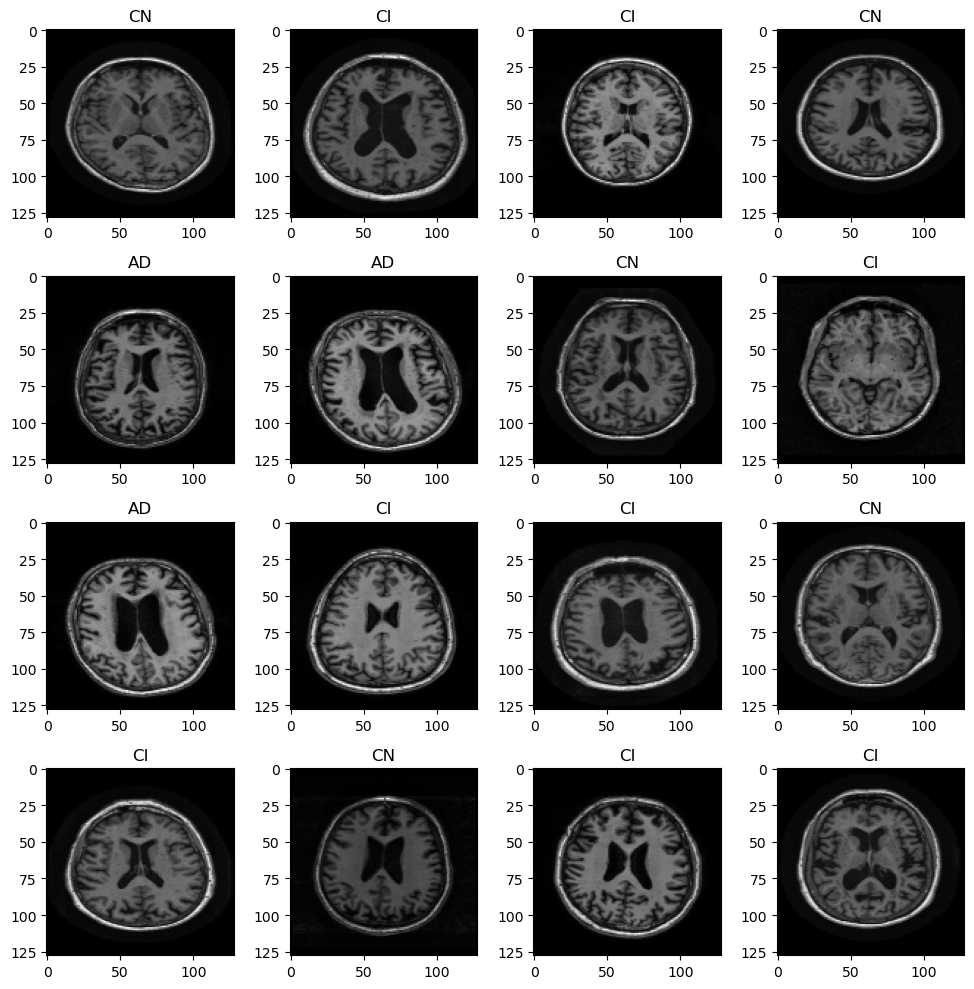

In [10]:
plt.figure(figsize = (10, 10))

for i in range(16):
    img = X[i]
    plt.subplot(4, 4, i + 1)
    plt.title(label_map[y[i]])
    plt.gray()
    plt.imshow(img)
    plt.tight_layout()
plt.show()

CN


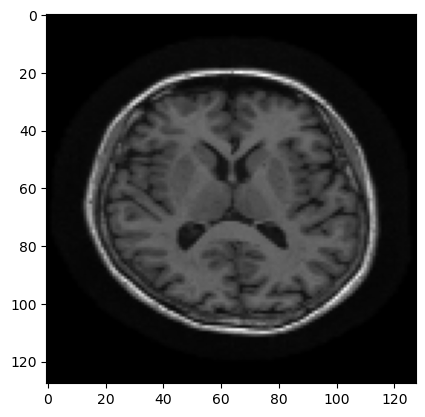

CI


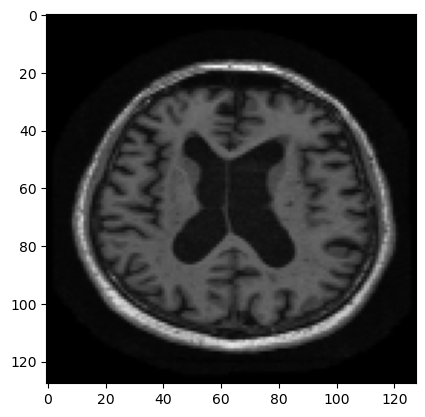

AD


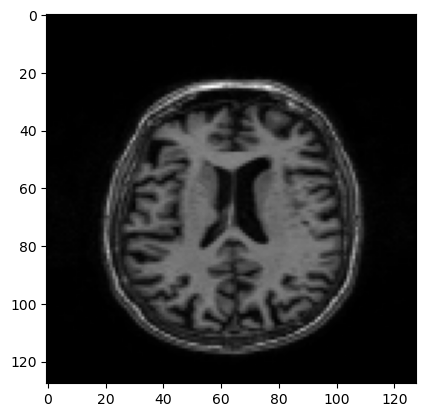

In [11]:
visited = set()

for img, label in zip(X_gray, y):
    if len(visited) == 3:
        break
    if label in visited:
        continue
    visited.add(label)
    print(label_map[label])
    plt.gray()
    plt.imshow(img)
    plt.show()

In [12]:
label_counts = pd.Series(y).value_counts()
print(label_counts)

1    2590
2    1440
0    1124
Name: count, dtype: int64


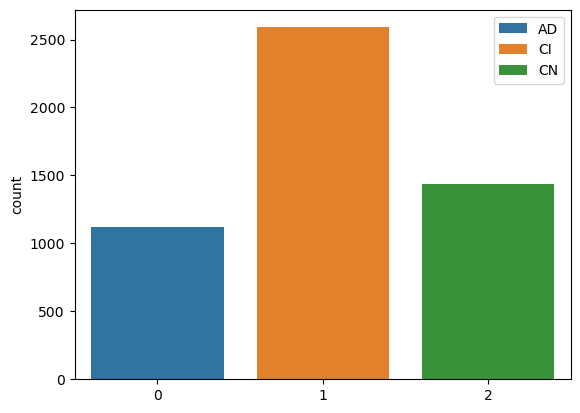

In [13]:
sns.countplot(x = y, label = label_map.values())
plt.legend()
plt.show()

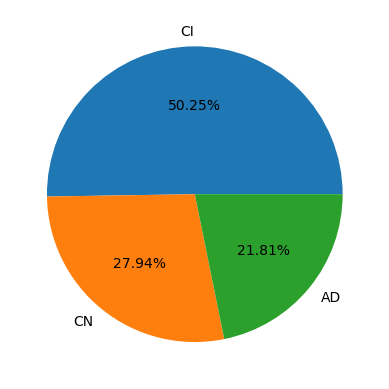

In [14]:
plt.pie(label_counts, autopct = "%.2f%%", labels = list(map(lambda key : label_map[key], label_counts.keys())))
plt.show()

In [15]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Create a data generator with augmentation
# data_gen = ImageDataGenerator(
#     rotation_range=20,  # Rotate images up to 20 degrees
#     width_shift_range=0.1,  # Shift images horizontally by 10%
#     height_shift_range=0.1,  # Shift images vertically by 10%
#     shear_range=0.1,  # Shearing
#     zoom_range=0.1,  # Zoom in/out by 10%
#     horizontal_flip=True,  # Flip images horizontally
#     fill_mode='nearest'  # Filling strategy for augmented pixels
# )

# data_augmentation = tf.keras.Sequential([
#     tf.keras.layers.RandomFlip(mode = "horizontal_and_vertical"),
# ])

In [16]:
# X_new, y_new = [], []
# max_total = 3000
# X_0, X_1, X_2 = X[y == 0], X[y == 1], X[y == 2]

# for label, X_set in zip(label_map.keys(), [X_0, X_1, X_2]):
#     count = 0
#     for img in X_set:
#         if count > max_total - label_counts[label]:
#             break
#         for i in range(2):
#             augmented_img = data_augmentation(img)
#             X_new.append(augmented_img)
#             y_new.append(label)
#             count += 1

# X_new, y_new = np.array(X_new), np.array(y_new)
# print(X_new.shape, y_new.shape)

import tensorflow as tf
import numpy as np

# Define the improved data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),              # Horizontal flip
    tf.keras.layers.RandomRotation(0.05),                  # Small rotation (5%)
    tf.keras.layers.RandomTranslation(0.05, 0.05),         # Small shift (5%)
    tf.keras.layers.RandomContrast(0.15),                  # Slight contrast variation (15%)
    tf.keras.layers.Lambda(lambda x: x + tf.random.normal(tf.shape(x), mean=0.0, stddev=0.01)),  # Add Gaussian noise
])

# Initialize lists for new augmented data
X_new, y_new = [], []
max_total = 3000
X_0, X_1, X_2 = X[y == 0], X[y == 1], X[y == 2]

# Generate augmented data per class to balance
for label, X_set in zip(label_map.keys(), [X_0, X_1, X_2]):
    count = 0
    for img in X_set:
        if count >= max_total - label_counts[label]:
            break
        for _ in range(3):  # Generate three augmentations per image
            augmented_img = data_augmentation(img[None, ...])  # Add batch dimension
            X_new.append(tf.squeeze(augmented_img).numpy())    # Squeeze and convert to numpy
            y_new.append(label)
            count += 1

# Convert lists to arrays and ensure dimensions match
X_new, y_new = np.array(X_new), np.array(y_new)

# Ensure `X` and `X_new` have the same number of dimensions
if X.ndim == 3:  # If X is [num_samples, height, width]
    X = np.expand_dims(X, axis=-1)  # Convert to [num_samples, height, width, channels]
if X_new.ndim == 3:
    X_new = np.expand_dims(X_new, axis=-1)

# Concatenate original and augmented datasets
X = np.concatenate([X, X_new], axis=0)
y = np.concatenate([y, y_new], axis=0)

print("Final augmented dataset shape:", X.shape, y.shape)



Final augmented dataset shape: (9003, 128, 128, 1) (9003,)


In [17]:
# X = np.concatenate([X, X_new])
# y = np.concatenate([y, y_new])

# print(X.shape, y.shape)

In [18]:
print(pd.Series(y).value_counts())

0    3002
1    3001
2    3000
Name: count, dtype: int64


In [19]:
# Min-Max Normalization

X = X / 255.0

print(X.min(), X.max())

-0.00021057010573499342 1.0000676772173713


In [20]:
# Splitting the data into training, testing and validation sets

X_train_val, X_test, y_train_val, y_test = model_selection.train_test_split(X, y, test_size = 0.15,
                                                                            random_state = 3, stratify = y)

X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train_val, y_train_val, test_size = 0.15,
                                                                  random_state = 3, stratify = y_train_val)

print(X_train.shape, X_val.shape, X_test.shape)

print(f"Total instances: {X.shape[0]}\nTrain instances: {X_train.shape[0]}   \
        \nValidation instances: {X_val.shape[0]}\nTest instances: {X_test.shape[0]}")

(6504, 128, 128, 1) (1148, 128, 128, 1) (1351, 128, 128, 1)
Total instances: 9003
Train instances: 6504           
Validation instances: 1148
Test instances: 1351


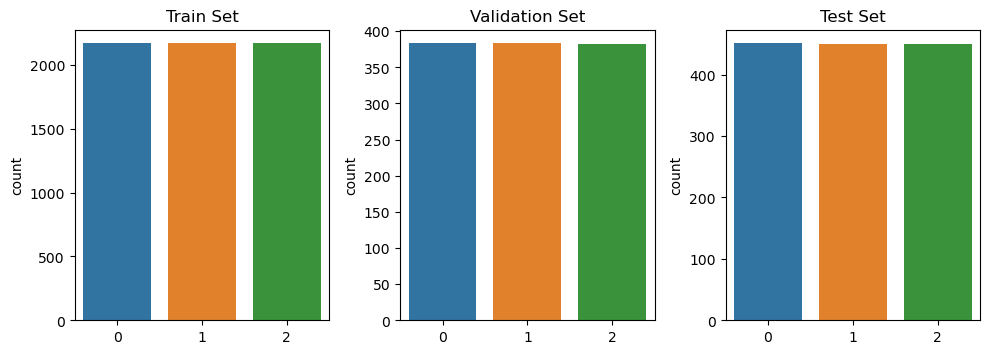

In [21]:
# Checking whether the classes are distributed uniformely among train, test and validation sets

plt.figure(figsize = (10, 10))

for i, labels, label_name in zip(range(3), [y_train, y_val, y_test], ["Train Set", "Validation Set", "Test Set"]):
    plt.subplot(3, 3, i + 1)
    plt.title(label_name)
    sns.countplot(x = labels)
    plt.tight_layout()
plt.show()

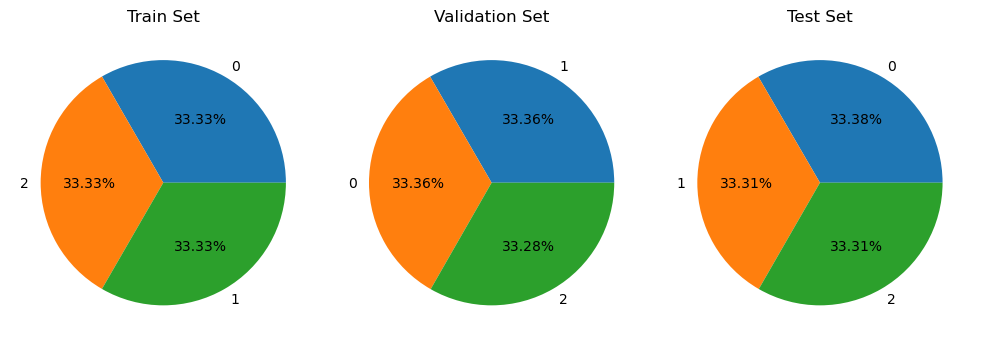

In [22]:
plt.figure(figsize = (10, 10))

for i, labels, label_name in zip(range(3), [y_train, y_val, y_test], ["Train Set", "Validation Set", "Test Set"]):
    plt.subplot(3, 3, i + 1)
    plt.title(label_name)
    label_counts = pd.Series(labels).value_counts()
    plt.pie(label_counts, autopct = "%.2f%%", labels = label_counts.keys())
    plt.tight_layout()
plt.show()

In [23]:
# # Model building

# model = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(filters = 200, kernel_size = (3, 3), input_shape = X_train.shape[1:], activation = "relu"),
#     tf.keras.layers.MaxPooling2D(pool_size = (3, 3)),
#     tf.keras.layers.Conv2D(filters = 100, kernel_size = (3, 3), input_shape = X_train.shape[1:], activation = "relu"),
#     tf.keras.layers.MaxPooling2D(pool_size = (3, 3)),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(units = 100, activation = "relu"),
#     tf.keras.layers.Dense(units = 50, activation = "relu"),
#     tf.keras.layers.Dense(units = 3, activation = "softmax")
# ])

from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

# Example of adding Dropout after dense layers
model = tf.keras.models.Sequential([
    # Example CNN layers
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1:])),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),

    # Adding L2 regularization to the Dense layer
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),

    # Add dropout layer here with a 30% dropout rate
    tf.keras.layers.Dropout(0.3),  # Adjust the dropout rate (0.3) as needed

    tf.keras.layers.Dense(128, activation='relu'),

    # Another dropout layer
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(units = 3, activation='softmax')
])


In [24]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,320,963 (12.67 MB)

 Trainable params: 3,320,963 (12.67 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
for idx, layer in enumerate(model.layers):
    print(f"Layer {idx}:", layer.name, layer.output.shape, layer.count_params())

Layer 0: conv2d (None, 126, 126, 32) 320
Layer 1: max_pooling2d (None, 63, 63, 32) 0
Layer 2: conv2d_1 (None, 61, 61, 64) 18496
Layer 3: max_pooling2d_1 (None, 30, 30, 64) 0
Layer 4: conv2d_2 (None, 28, 28, 128) 73856
Layer 5: max_pooling2d_2 (None, 14, 14, 128) 0
Layer 6: flatten (None, 25088) 0
Layer 7: dense (None, 128) 3211392
Layer 8: dropout (None, 128) 0
Layer 9: dense_1 (None, 128) 16512
Layer 10: dropout_1 (None, 128) 0
Layer 11: dense_2 (None, 3) 387


In [26]:
model_arch = tf.keras.utils.plot_model(model, show_shapes = True)
model_arch

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [27]:
model.compile(optimizer = "adam", loss = "SparseCategoricalCrossentropy", metrics = ["accuracy"])

In [28]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Create a data generator with augmentation
# data_gen = ImageDataGenerator(
#     rotation_range=20,  # Rotate images up to 20 degrees
#     width_shift_range=0.1,  # Shift images horizontally by 10%
#     height_shift_range=0.1,  # Shift images vertically by 10%
#     shear_range=0.1,  # Shearing
#     zoom_range=0.1,  # Zoom in/out by 10%
#     horizontal_flip=True,  # Flip images horizontally
#     fill_mode='nearest'  # Filling strategy for augmented pixels
# )

In [29]:
cb1 = tf.keras.callbacks.ModelCheckpoint("clf_model.keras", save_best_only=True)
cb2 = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
cb3 = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.01)

history = model.fit(X_train, y_train, epochs=100, callbacks=[cb1, cb2, cb3], validation_data=(X_val, y_val))

# cb1 = tf.keras.callbacks.ModelCheckpoint("clf_model.keras", save_best_only=True)
# cb2 = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
# cb3 = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)

# # Add the new callback to the list
# history = model.fit(
#     data_gen.flow(X_train, y_train, batch_size=32),
#     epochs=100,
#     validation_data=(X_val, y_val),
#     callbacks=[cb1, cb2, cb3]
# )

Epoch 1/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 30s 135ms/step - accuracy: 0.4121 - loss: 1.1479 - val_accuracy: 0.5889 - val_loss: 0.9184 - learning_rate: 0.0010
Epoch 2/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 28s 135ms/step - accuracy: 0.5947 - loss: 0.8952 - val_accuracy: 0.7256 - val_loss: 0.6912 - learning_rate: 0.0010
Epoch 3/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 29s 143ms/step - accuracy: 0.7239 - loss: 0.6899 - val_accuracy: 0.8031 - val_loss: 0.5646 - learning_rate: 0.0010
Epoch 4/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 30s 146ms/step - accuracy: 0.8172 - loss: 0.5506 - val_accuracy: 0.8545 - val_loss: 0.4722 - learning_rate: 0.0010
Epoch 5/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 30s 146ms/step - accuracy: 0.8621 - loss: 0.4619 - val_accuracy: 0.8876 - val_loss: 0.4375 - learning_rate: 0.0010
Epoch 6/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 29s 140ms/step - accuracy: 0.8759 - loss: 0.4256 - val_accuracy: 0.8746 - val_loss: 0.4270 - learning_rate: 0.0010
Epoch 7/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 28s 138ms/step - accura

In [30]:
result_df = pd.DataFrame(history.history)
result_df.head()

,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.454490,1.071382,0.588850,0.918410,0.001
1,0.634071,0.851949,0.725610,0.691165,0.001
2,0.741236,0.671928,0.803136,0.564568,0.001
3,0.824108,0.541620,0.854530,0.472170,0.001
4,0.862392,0.460205,0.887631,0.437500,0.001


In [31]:
result_df.describe()

,accuracy,loss,val_accuracy,val_loss,learning_rate
count,14.000000,14.000000,14.000000,14.000000,14.000
mean,0.846885,0.465667,0.857081,0.475846,0.001
std,0.144942,0.242165,0.093916,0.154129,0.000
min,0.454490,0.262233,0.588850,0.375528,0.001
25%,0.833679,0.310454,0.859538,0.393489,0.001
50%,0.911593,0.352746,0.898084,0.410731,0.001
75%,0.936155,0.521266,0.910279,0.463503,0.001
max,0.955720,1.071382,0.918990,0.918410,0.001


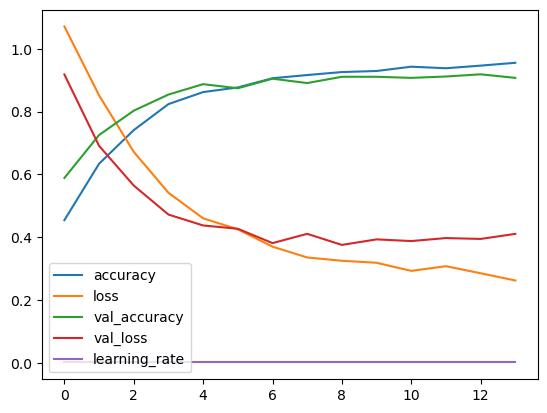

In [32]:
result_df.plot()
plt.show()


In [33]:
loss, acc = model.evaluate(X_train, y_train)

204/204 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.9763 - loss: 0.2111


In [34]:
# Confusion Matrix

y_train_pred = model.predict(X_train)
y_train_pred_labels = np.array([np.argmax(y_) for y_ in y_train_pred])

cm = tf.math.confusion_matrix(labels = y_train, predictions = y_train_pred_labels)
print(cm)

204/204 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step
tf.Tensor(
[[2158    1    9]
 [  63 2075   30]
 [  49    0 2119]], shape=(3, 3), dtype=int32)


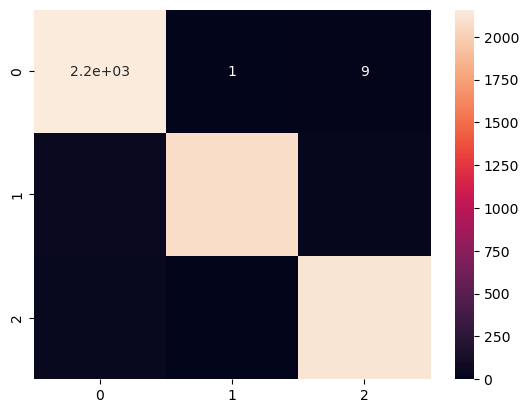

In [35]:
sns.heatmap(cm, annot = True)
plt.show()

In [36]:
tp_0, tn_0 = cm[0][0], cm[1][1] + cm[1][2] + cm[2][1] + cm[2][2]
fp_0, fn_0 = cm[1][0] + cm[2][0], cm[0][1] + cm[0][2]

tp_1, tn_1 = cm[1][1], cm[0][0] + cm[0][2] + cm[2][0] + cm[2][2]
fp_1, fn_1 = cm[0][1] + cm[2][1], cm[1][0] + cm[1][2]

tp_2, tn_2 = cm[2][2], cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1]
fp_2, fn_2 = cm[0][2] + cm[1][2], cm[2][0] + cm[2][1]

def describeCM(tp, tn, fp, fn, i):
    print(f"\n\nClass {label_map[i]} : \n")
    print(f"True Positives : {tp}\nTrue Negatives : {tn}\nFalse Positives : {fp}\nFalse Negatives : {fn}")
    precision, recall = tp / (tp + fp), tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    print(f"\nPrecision : {precision}\nRecall (Sensitivity) : {recall}\nF1-Score : {f1}")

describeCM(tp_0, tn_0, fp_0, fn_0, 0)
describeCM(tp_1, tn_1, fp_1, fn_1, 1)
describeCM(tp_2, tn_2, fp_2, fn_2, 2)



Class AD : 

True Positives : 2158
True Negatives : 4224
False Positives : 112
False Negatives : 10

Precision : 0.9506607929515418
Recall (Sensitivity) : 0.9953874538745388
F1-Score : 0.9725101397025686


Class CI : 

True Positives : 2075
True Negatives : 4335
False Positives : 1
False Negatives : 93

Precision : 0.9995183044315993
Recall (Sensitivity) : 0.9571033210332104
F1-Score : 0.9778510838831291


Class CN : 

True Positives : 2119
True Negatives : 4297
False Positives : 39
False Negatives : 49

Precision : 0.9819277108433735
Recall (Sensitivity) : 0.9773985239852399
F1-Score : 0.9796578825705039


In [37]:
clf_report = metrics.classification_report(y_train, y_train_pred_labels)
print(clf_report)

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      2168
           1       1.00      0.96      0.98      2168
           2       0.98      0.98      0.98      2168

    accuracy                           0.98      6504
   macro avg       0.98      0.98      0.98      6504
weighted avg       0.98      0.98      0.98      6504



In [38]:
# Evaluating the model on test set

loss, acc = model.evaluate(X_test, y_test)

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9229 - loss: 0.3390


43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


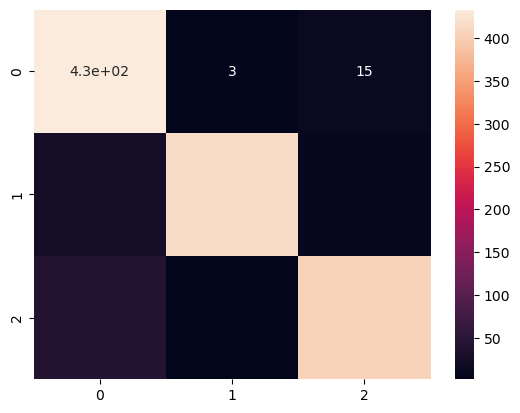

In [39]:
# Confusion Matrix

y_test_pred = model.predict(X_test)
y_test_pred_labels = np.array([np.argmax(y_) for y_ in y_test_pred])

cm = tf.math.confusion_matrix(labels = y_test, predictions = y_test_pred_labels)

sns.heatmap(cm, annot = True)
plt.show()

In [40]:
tp_0, tn_0 = cm[0][0], cm[1][1] + cm[1][2] + cm[2][1] + cm[2][2]
fp_0, fn_0 = cm[1][0] + cm[2][0], cm[0][1] + cm[0][2]

tp_1, tn_1 = cm[1][1], cm[0][0] + cm[0][2] + cm[2][0] + cm[2][2]
fp_1, fn_1 = cm[0][1] + cm[2][1], cm[1][0] + cm[1][2]

tp_2, tn_2 = cm[2][2], cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1]
fp_2, fn_2 = cm[0][2] + cm[1][2], cm[2][0] + cm[2][1]

def describeCM(tp, tn, fp, fn, i):
    print(f"\n\nClass {label_map[i]} : \n")
    print(f"True Positives : {tp}\nTrue Negatives : {tn}\nFalse Positives : {fp}\nFalse Negatives : {fn}")
    precision, recall = tp / (tp + fp), tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    print(f"\nPrecision : {precision}\nRecall (Sensitivity) : {recall}\nF1-Score : {f1}")

describeCM(tp_0, tn_0, fp_0, fn_0, 0)
describeCM(tp_1, tn_1, fp_1, fn_1, 1)
describeCM(tp_2, tn_2, fp_2, fn_2, 2)



Class AD : 

True Positives : 433
True Negatives : 831
False Positives : 69
False Negatives : 18

Precision : 0.8625498007968128
Recall (Sensitivity) : 0.9600886917960089
F1-Score : 0.9087093389296957


Class CI : 

True Positives : 415
True Negatives : 896
False Positives : 5
False Negatives : 35

Precision : 0.9880952380952381
Recall (Sensitivity) : 0.9222222222222223
F1-Score : 0.9540229885057472


Class CN : 

True Positives : 405
True Negatives : 877
False Positives : 24
False Negatives : 45

Precision : 0.9440559440559441
Recall (Sensitivity) : 0.9
F1-Score : 0.9215017064846417


In [41]:
# Classification Report

clf_report = metrics.classification_report(y_test, y_test_pred_labels)
print(clf_report)

              precision    recall  f1-score   support

           0       0.86      0.96      0.91       451
           1       0.99      0.92      0.95       450
           2       0.94      0.90      0.92       450

    accuracy                           0.93      1351
   macro avg       0.93      0.93      0.93      1351
weighted avg       0.93      0.93      0.93      1351



In [42]:
model.save("clf_model_final.h5")

In [43]:
import os

import keras
from keras import layers
from keras import ops
import numpy as np

In [52]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.5,
        temperature=3,
    ):
        """Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def compute_loss(
        self, x=None, y=None, y_pred=None, sample_weight=None, allow_empty=False
    ):
        teacher_pred = self.teacher(x, training=False)
        student_loss = self.student_loss_fn(y, y_pred)

        distillation_loss = self.distillation_loss_fn(
            ops.softmax(teacher_pred / self.temperature, axis=1),
            ops.softmax(y_pred / self.temperature, axis=1),
        ) * (self.temperature**2)

        loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss
        return loss

    def call(self, x):
        return self.student(x)

In [53]:
# teacher =  tf.keras.models.Sequential([
#     # Example CNN layers
#     tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1:])),
#     tf.keras.layers.MaxPooling2D((2, 2)),

#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D((2, 2)),

#     tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D((2, 2)),

#     tf.keras.layers.Flatten(),

#     # Adding L2 regularization to the Dense layer
#     tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),

#     # Add dropout layer here with a 30% dropout rate
#     tf.keras.layers.Dropout(0.3),  # Adjust the dropout rate (0.3) as needed

#     tf.keras.layers.Dense(128, activation='relu'),

#     # Another dropout layer
#     tf.keras.layers.Dropout(0.3),

#     tf.keras.layers.Dense(units = 3, activation='softmax')
# ])

teacher = model

student = keras.Sequential(
    [
        tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(X_train.shape[1:])),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Flatten(),

    # L2 regularization is still applied, but with fewer units in Dense layer
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(0.001)),

    # Add dropout layer here with a 30% dropout rate
        tf.keras.layers.Dropout(0.3),

    # Reduced size of the second Dense layer
        tf.keras.layers.Dense(64, activation='relu'),

    # Another dropout layer
        tf.keras.layers.Dropout(0.3),

    # Final output layer with the same number of units as the teacher
        tf.keras.layers.Dense(units=3, activation='softmax')
    ],
    name="student",
)
student_scratch = keras.models.clone_model(student)

In [54]:
student_scratch.summary()

Model: "student"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 126, 126, 16)        │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 63, 63, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 61, 61, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │         802,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 830,531 (3.17 MB)

 Trainable params: 830,531 (3.17 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
# Compile the teacher model
teacher.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

# Train the teacher model on data with a validation set
teacher.fit(X_train, y_train, 
            epochs=10)  # Include validation data

# Evaluate the teacher model on the test dataset
teacher.evaluate(X_test, y_test)

Epoch 1/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 30s 138ms/step - loss: 0.1708 - sparse_categorical_accuracy: 0.9696
Epoch 2/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 28s 138ms/step - loss: 0.1926 - sparse_categorical_accuracy: 0.9604
Epoch 3/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 27s 131ms/step - loss: 0.1828 - sparse_categorical_accuracy: 0.9657
Epoch 4/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 28s 135ms/step - loss: 0.1759 - sparse_categorical_accuracy: 0.9699
Epoch 5/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 29s 141ms/step - loss: 0.1777 - sparse_categorical_accuracy: 0.9703
Epoch 6/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - loss: 0.2158 - sparse_categorical_accuracy: 0.9625
Epoch 7/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 29s 141ms/step - loss: 0.2091 - sparse_categorical_accuracy: 0.9662
Epoch 8/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 29s 141ms/step - loss: 0.1762 - sparse_categorical_accuracy: 0.9779
Epoch 9/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 28s 135ms/step - loss: 0.1798 - sparse_categorical_accuracy: 0.9756
Epoch 10/10
204/204 ━━━━━━━━

[0.3738827407360077, 0.9296817183494568]

In [56]:
# Train student as doen usually
student_scratch.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

# Train and evaluate student trained from scratch.
student_scratch.fit(X_train, y_train, epochs=7)
student_scratch.evaluate(X_test, y_test)

Epoch 1/7
204/204 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 1.1282 - sparse_categorical_accuracy: 0.3683
Epoch 2/7
204/204 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 0.9572 - sparse_categorical_accuracy: 0.5432
Epoch 3/7
204/204 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 0.7438 - sparse_categorical_accuracy: 0.6911
Epoch 4/7
204/204 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - loss: 0.6156 - sparse_categorical_accuracy: 0.7718
Epoch 5/7
204/204 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 0.4801 - sparse_categorical_accuracy: 0.8460
Epoch 6/7
204/204 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - loss: 0.4443 - sparse_categorical_accuracy: 0.8568
Epoch 7/7
204/204 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - loss: 0.3864 - sparse_categorical_accuracy: 0.8856
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.3825 - sparse_categorical_accuracy: 0.8896


[0.3792159855365753, 0.8919318914413452]